In [1]:
from astropy.io import fits
import astropy.units as u
from astropy.visualization import simple_norm
from photutils.aperture import CircularAperture, ApertureStats  # photutils v1.5

In [2]:
import numpy as np
from glob import glob
import os

In [3]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
#%matplotlib inline   # non-interactive (easier for notebook scrolling)
%matplotlib notebook
#plt.style.use(os.path.join(home, 'p', 'matplotlibrc.txt')) # https://matplotlib.org/tutorials/introductory/customizing.html
plt.style.use('https://www.stsci.edu/~dcoe/matplotlibrc.txt') # https://matplotlib.org/tutorials/introductory/customizing.html
mpl_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
image_dir = '../images/grizli_v2'
image_files_list = glob(os.path.join(image_dir, '*.fits'))
image_files_list = np.sort(image_files_list)

def extract_filter(image_file):
    return os.path.basename(image_file).split('_')[0].lower().split('-')[3]

image_files_dict = {}
filters = list(map(extract_filter, image_files_list))
for i in range(len(filters)):
    image_files_dict[filters[i]] = image_files_list[i]    
    print(filters[i], image_files_list[i])

f090w ../images/grizli_v2/sunrise-grizli-v2-f090w-clear_40mas_sci.fits
f105w ../images/grizli_v2/sunrise-grizli-v2-f105w_drz_sci.fits
f110w ../images/grizli_v2/sunrise-grizli-v2-f110w_drz_sci.fits
f115w ../images/grizli_v2/sunrise-grizli-v2-f115w-clear_40mas_sci.fits
f125w ../images/grizli_v2/sunrise-grizli-v2-f125w_drz_sci.fits
f140w ../images/grizli_v2/sunrise-grizli-v2-f140w_drz_sci.fits
f150w ../images/grizli_v2/sunrise-grizli-v2-f150w-clear_40mas_sci.fits
f160w ../images/grizli_v2/sunrise-grizli-v2-f160w_drz_sci.fits
f200w ../images/grizli_v2/sunrise-grizli-v2-f200w-clear_40mas_sci.fits
f277w ../images/grizli_v2/sunrise-grizli-v2-f277w-clear_drc_sci.fits
f356w ../images/grizli_v2/sunrise-grizli-v2-f356w-clear_drc_sci.fits
f410m ../images/grizli_v2/sunrise-grizli-v2-f410m-clear_drc_sci.fits
f435w ../images/grizli_v2/sunrise-grizli-v2-f435w_drc_sci.fits
f444w ../images/grizli_v2/sunrise-grizli-v2-f444w-clear_drc_sci.fits
f475w ../images/grizli_v2/sunrise-grizli-v2-f475w_drc_sci.fits

In [8]:
nircam_filters = 'f090w f115w f150w f200w f277w f356w f410m f444w'.split()

In [5]:
def measure_photometry(filt, verbose=True):
    image_file = image_files_dict[filt]
    image_data = fits.getdata(image_file)

    apstats = ApertureStats(image_data, aper)
    bkg1 = ApertureStats(image_data, bkgaper1)
    bkg2 = ApertureStats(image_data, bkgaper2)
    bkg = np.mean((bkg1.sum, bkg2.sum))

    flux = (apstats.sum - bkg) * 10. * u.nJy  # nJy; BUNIT = 10 nJy
    if filt in 'f090w f115w f150w f200w'.split():
        flux *= 4

    #abmag = -2.5 * np.log10(flux.value) + 31.4
    mag = flux.to(u.ABmag)
    if verbose:
        #print(filt.ljust(6), ' %5.2f nJy' % flux.value, '  %5.2f mag AB' % mag.value)    
        print(filt.ljust(6), ' %5.2f nJy' % flux.value, '  %5.2f mag AB' % mag.value,
              ':  %5.2f flux - %5.2f background' % (10*apstats.sum, 10*bkg))
    else:
        print(' %5.2f' % flux.value)

    return flux

In [13]:
filt = 'f200w'

In [14]:
image_file = image_files_dict[filt]
image_data = fits.getdata(image_file)

5.0
7.84956496544413 nJy


<IPython.core.display.Javascript object>


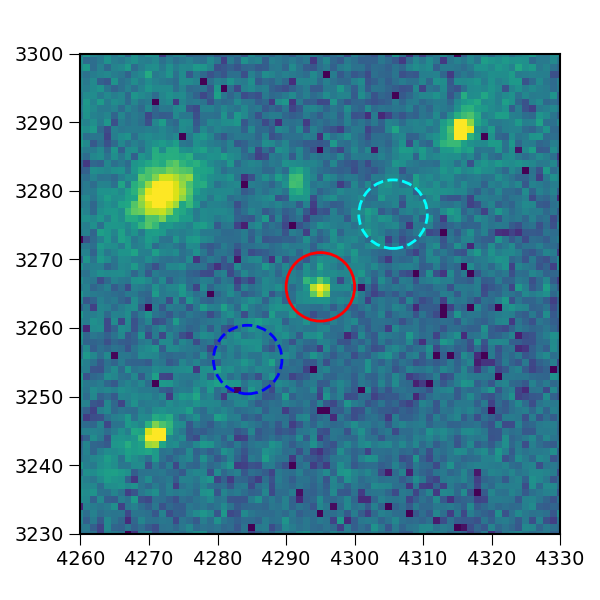

(<matplotlib.patches.Circle at 0x18643e350>,)

In [15]:
# Measure background at same locations regardless of aperture size

#r = radius = 6. # pixels
r = radius = 0.2 / 0.04
print(r)
x, y = 4295, 3266  # Earendel
#k = 1.5 # separation factor
sep = 0.6 / 0.04 / np.sqrt(2)
aper = CircularAperture((x, y), r=radius)
bkgaper1 = CircularAperture((x-sep, y-sep), r=radius)
bkgaper2 = CircularAperture((x+sep, y+sep), r=radius)

apstats = ApertureStats(image_data, aper)
bkg1 = ApertureStats(image_data, bkgaper1)
bkg2 = ApertureStats(image_data, bkgaper2)
bkg = np.mean((bkg1.sum, bkg2.sum))

flux = (apstats.sum - bkg) * 10. * u.nJy  # nJy; BUNIT = 10 nJy
print(flux)

image_file = image_files_dict[filt]
image_data = fits.getdata(image_file)

fig = plt.figure(figsize=(6, 6))
norm = simple_norm(image_data, 'sqrt', percent=99.)
plt.imshow(image_data, norm=norm)
plt.xlim(4260, 4330)
plt.ylim(3230, 3300)
aper.plot(color='red', lw=2)
bkgaper1.plot(color='b', lw=2, ls='--')
bkgaper2.plot(color='cyan', lw=2, ls='--')
#fig.savefig('Earendel_apertures_r20mas.png')

In [16]:
image_flux_units = 10 * u.nJy  # in all Gabe's grizli images: BUNIT = 10 nJy

In [21]:
def extract_lam(filt):
    lam = int(filt[1:4])/100.
    if filt in 'f435w f475w f606w f814w'.split():
        lam /= 10
    return lam #* u.um

In [34]:
nircam_lams = list(map(extract_lam, nircam_filters))
nircam_lams

[0.9, 1.15, 1.5, 2.0, 2.77, 3.56, 4.1, 4.44]

In [55]:
import astropy.io.ascii

In [56]:
encircled_energy_SW = astropy.io.ascii.read('Encircled_Energy_SW.txt', header_start=3)
encircled_energy_LW = astropy.io.ascii.read('Encircled_Energy_LW.txt', header_start=3)

encircled_energy = encircled_energy_SW[:]
for label in encircled_energy_LW.columns:
    encircled_energy[label] = encircled_energy_LW[label]

In [57]:
rarcsec = 0.2
i_ee = np.argmin(np.abs(encircled_energy['aperture_radius'] - rarcsec))

In [58]:
filt = 'f444w'
image_data = fits.getdata(image_files_dict[filt])

<IPython.core.display.Javascript object>


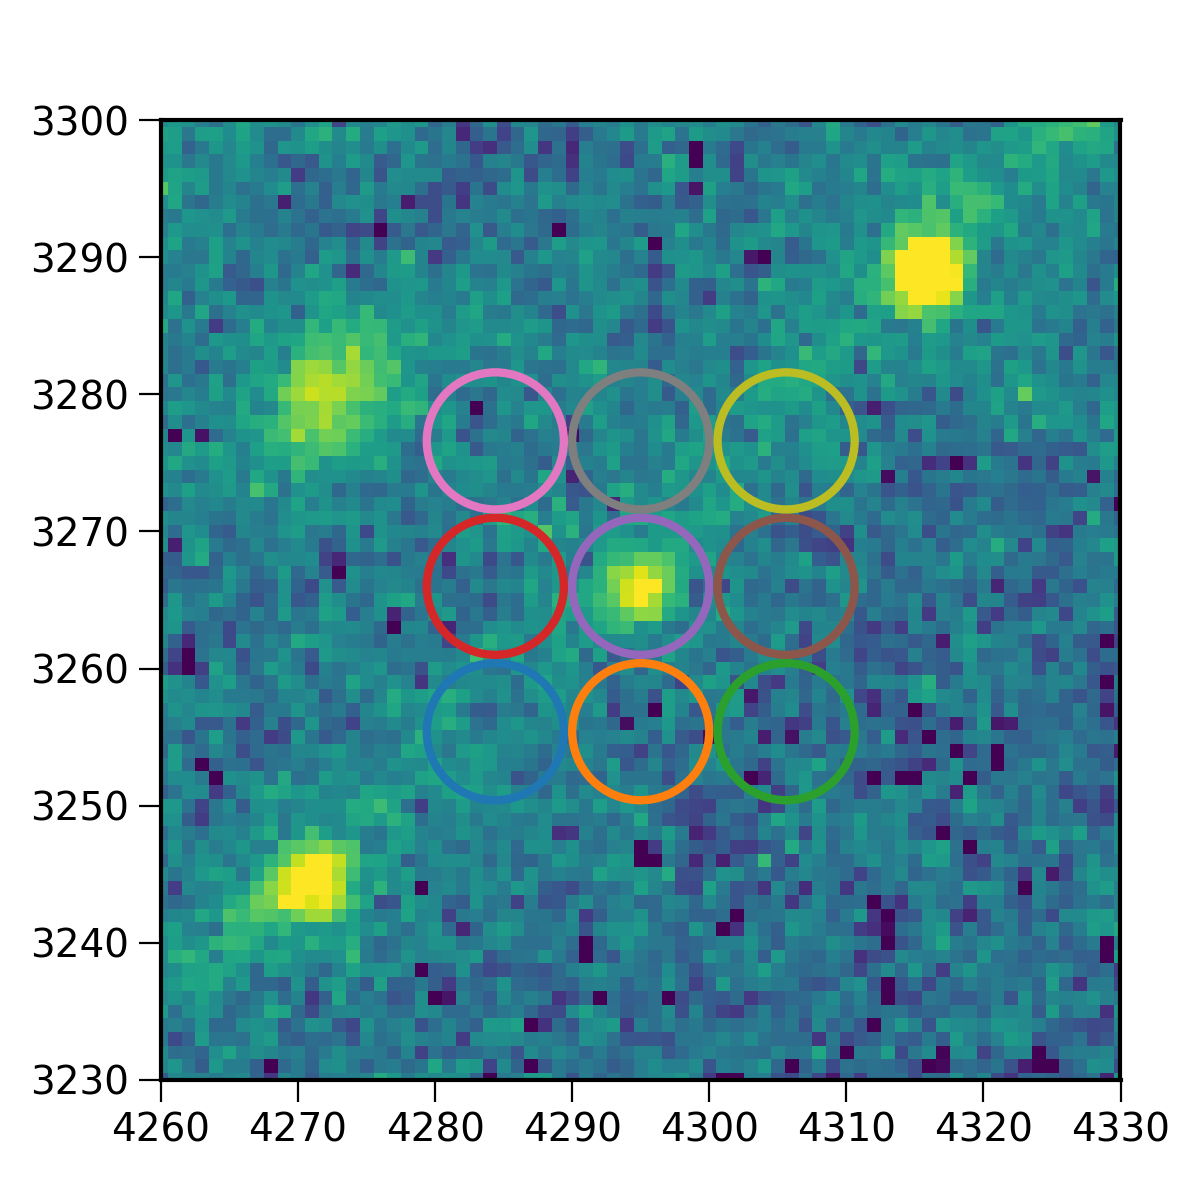

16.56500311334626 nJy
-5.958238854464428 nJy
-12.0186642450111 nJy
10.975684254477539 nJy
82.98890604213057 nJy
-1.4473685246902137 nJy
8.085687103547684 nJy
14.425658304167522 nJy
25.780943797514016 nJy


In [59]:
# Measure background at same locations regardless of aperture size

r = radius = 0.2 / 0.04  # 0.2" = 5 pixels
x, y = 4295, 3266  # Earendel
sep = 0.6 / 0.04 / np.sqrt(2)  # separation

fig = plt.figure(figsize=(6, 6))
norm = simple_norm(image_data, 'sqrt', percent=99.)
plt.imshow(image_data, norm=norm)

i = 0
for iy in -1,0,1:
    for ix in -1,0,1:
        aper = CircularAperture((x+ix*sep, y+iy*sep), r=radius)
        bkg = ApertureStats(image_data, aper)
        flux = bkg.sum * image_flux_units
        if filt in 'f090w f115w f150w f200w':
            flux *= 4  # 2x2 pixel rebinning

        ee = encircled_energy[filt.upper()][i_ee]
        flux = flux / ee  # encircled energy correction

        print(flux)
        aper.plot(lw=3, color=mpl_colors[i])
        i += 1

plt.xlim(4260, 4330)
plt.ylim(3230, 3300)

plt.savefig('Earendel_apertures_%s.png' % filt)

<IPython.core.display.Javascript object>


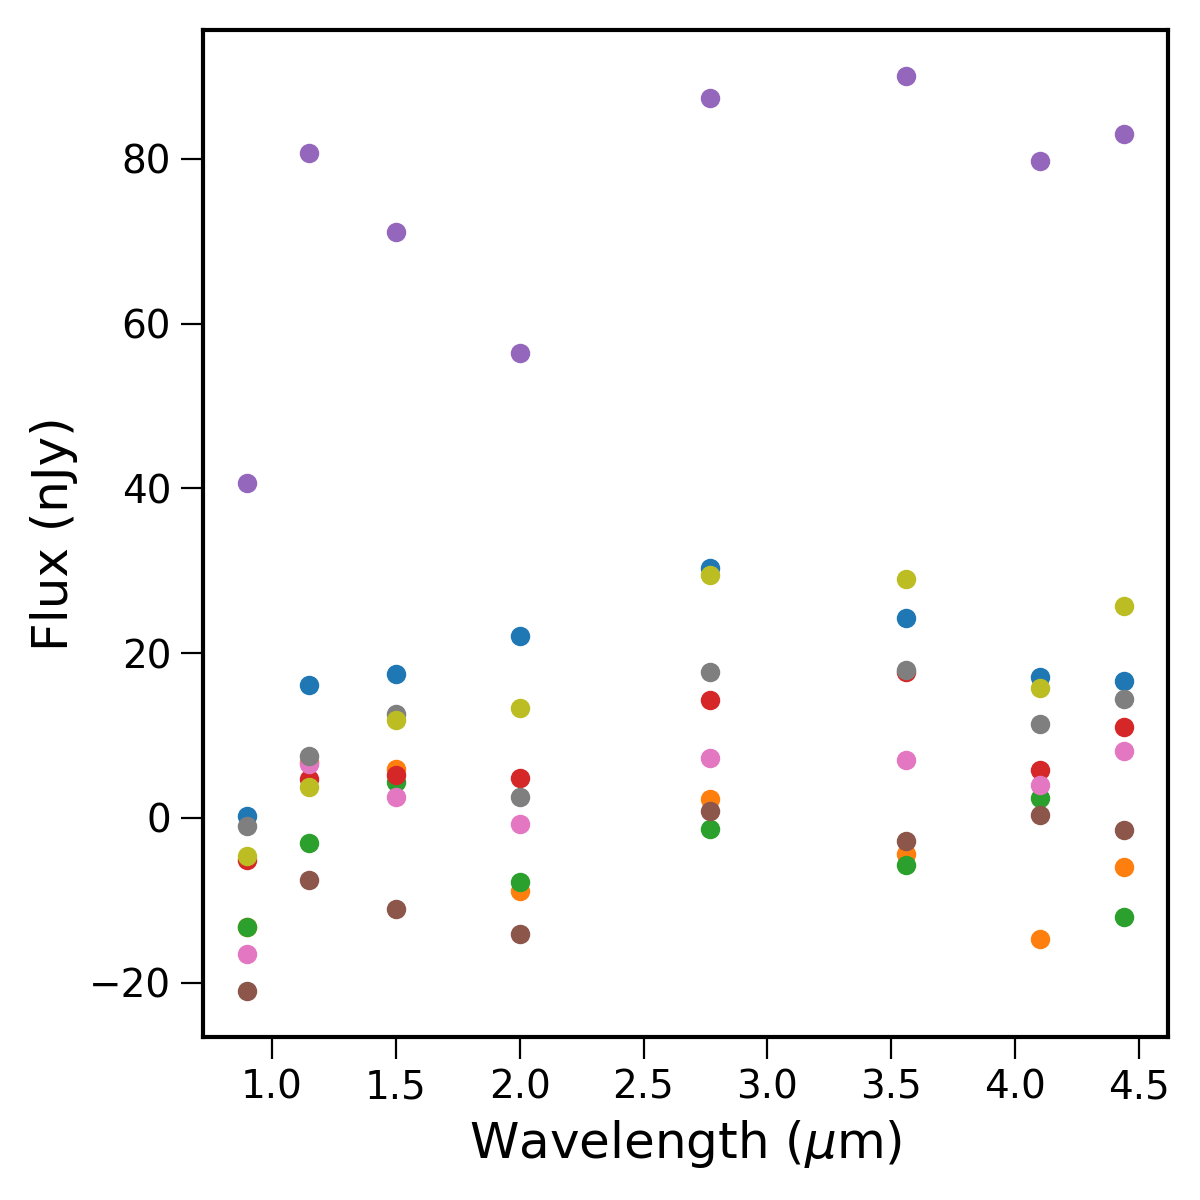

Text(0, 0.5, 'Flux (nJy)')

In [60]:
# Measure background at same locations regardless of aperture size

fig = plt.figure(figsize=(6, 6))

for ifilt, filt in enumerate(nircam_filters):
    image_data = fits.getdata(image_files_dict[filt])
    i = 0
    for iy in -1,0,1:
        for ix in -1,0,1:
            aper = CircularAperture((x+ix*sep, y+iy*sep), r=radius)
            bkg = ApertureStats(image_data, aper)
            flux = bkg.sum * image_flux_units
            if filt in 'f090w f115w f150w f200w':
                flux *= 4  # 2x2 pixel rebinning

            flux = flux / encircled_energy[filt.upper()][i_ee]  # encircled energy correction

            #print(flux)
            color=mpl_colors[i]
            i += 1
            lam = extract_lam(filt)
            plt.plot(lam, flux, 'o', color=color)

plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Flux (nJy)')

In [68]:
# Measure background at same locations regardless of aperture size

aper_fluxes = []
for iy in -1,0,1:
    for ix in -1,0,1:
        fluxes = []
        for ifilt, filt in enumerate(nircam_filters):
            image_data = fits.getdata(image_files_dict[filt])
            aper = CircularAperture((x+ix*sep, y+iy*sep), r=radius)
            bkg = ApertureStats(image_data, aper)
            flux = bkg.sum * image_flux_units
            if filt in 'f090w f115w f150w f200w':
                flux *= 4  # 2x2 pixel rebinning
            flux = flux / encircled_energy[filt.upper()][i_ee]  # encircled energy correction
            fluxes.append(flux.value)
        aper_fluxes.append(fluxes)
        
aper_fluxes = np.array(aper_fluxes)
obj_fluxes = aper_fluxes[4]
aper_fluxes.shape

(9, 8)

In [69]:
obj_fluxes

array([40.62569933, 80.66940406, 71.15276351, 56.43371289, 87.42069688,
       90.09549528, 79.69357627, 82.98890604])

<IPython.core.display.Javascript object>


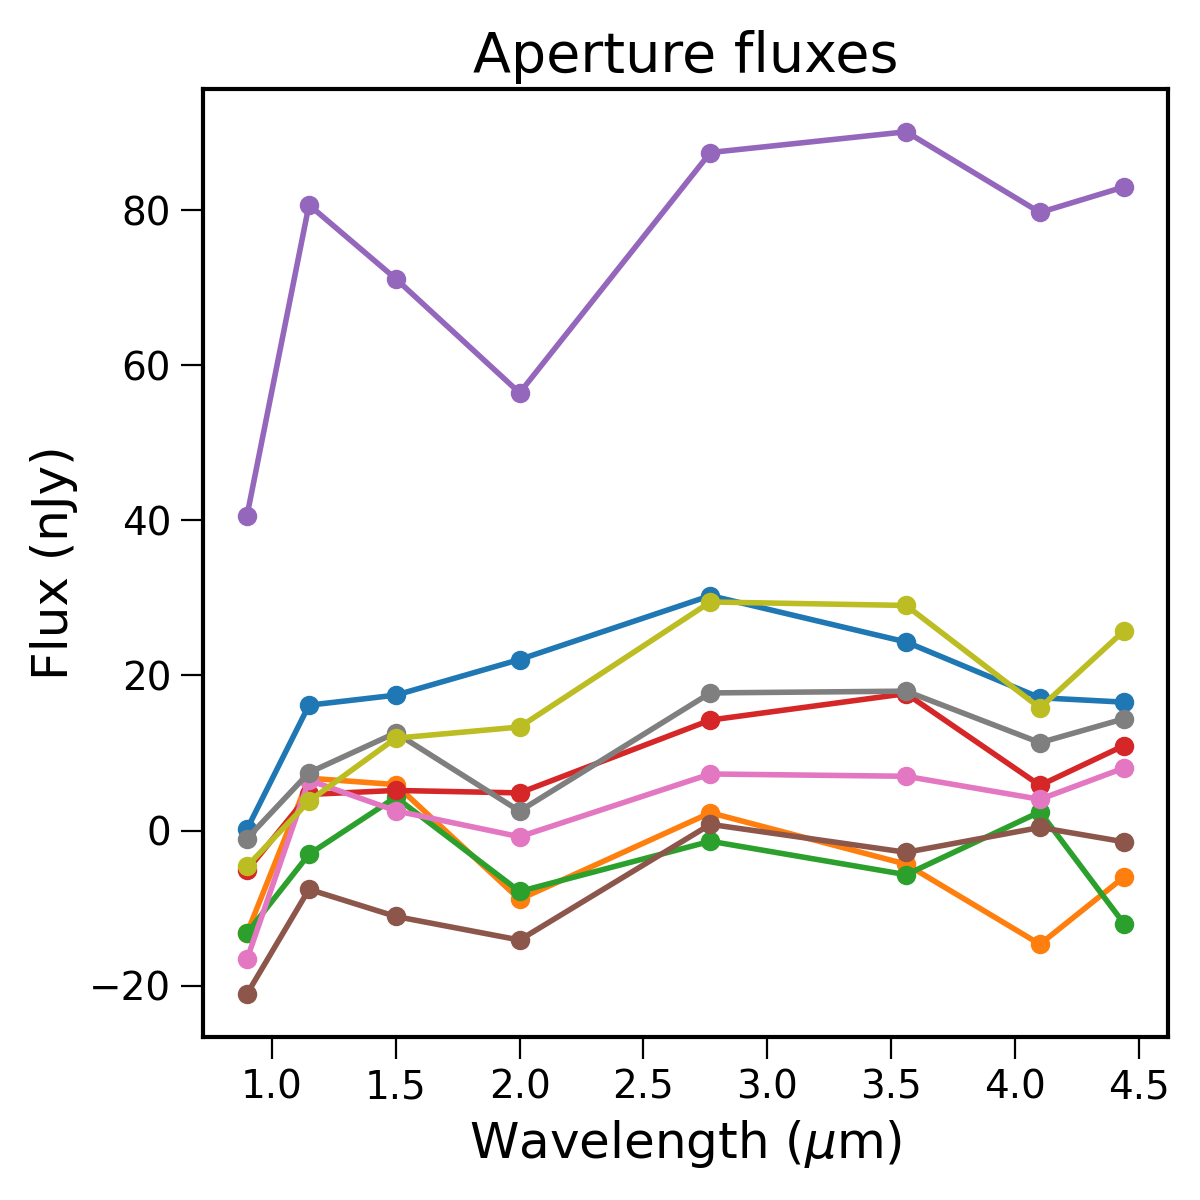

In [70]:
fig = plt.figure(figsize=(6, 6))

for i in range(9):
    color = mpl_colors[i]
    plt.plot(nircam_lams, aper_fluxes[i], 'o-', color=color)

plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Flux (nJy)')
plt.title('Aperture fluxes')
plt.savefig('aperture_fluxes.png')

<IPython.core.display.Javascript object>


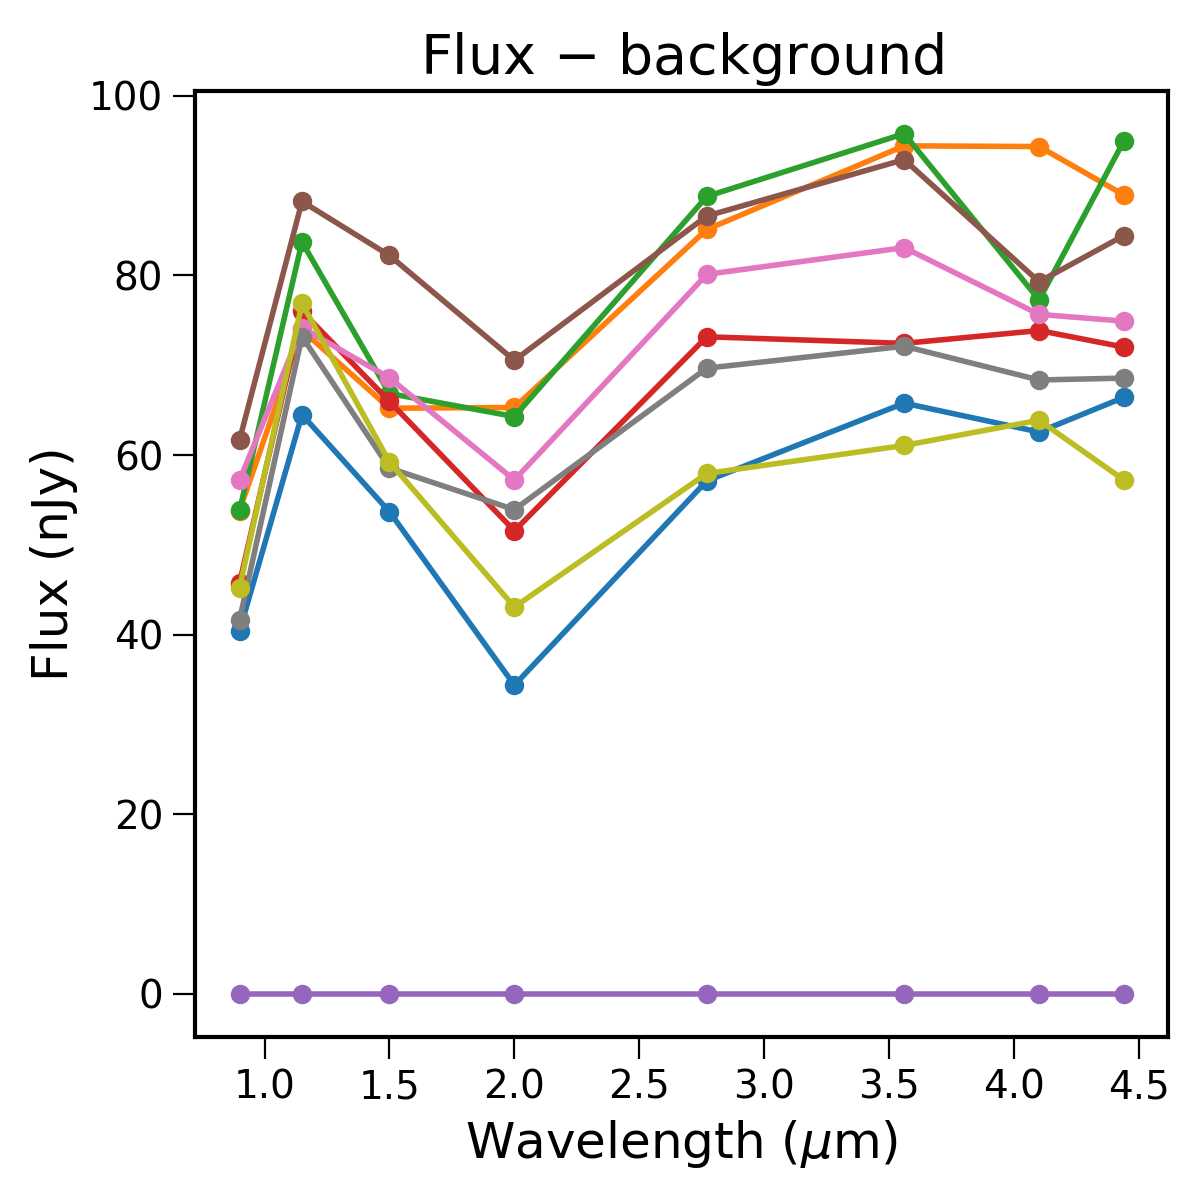

In [71]:
fig = plt.figure(figsize=(6, 6))

for i in range(9):
    color = mpl_colors[i]
    fluxes = obj_fluxes - aper_fluxes[i]
    plt.plot(nircam_lams, fluxes, 'o-', color=color)

plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Flux (nJy)')

plt.title('Flux $-$ background')
plt.savefig('flux-background.png')